# Statystyka stosowana - Raport 2  
**Emil Olszewski**

## Testowanie hipotez statystycznych

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd 
from scipy.optimize import curve_fit

In [22]:
plt.style.use("seaborn-v0_8-notebook")

In [3]:
"""
    Funkcja zwracająca dane ze strony www.
"""
def load_data(path: str):

    df: pd.DataFrame = pd.read_csv(path, header=None)
    return np.array(df[0])
    

In [4]:
"""
    Funkcja tworząca wykres zbiorów krytycznych danego testu
"""
def plot_test(
        test_stat,          # statystyka testowa
        lower_bound=None,   # dolna wartość krytyczna
        upper_bound=None,   # górna wartość krytyczna
        dist=st.norm        # rozkład z jakiego pochodzi statystyka
):
    
    
    lo, hi = dist.ppf(0.001), dist.ppf(0.999)  # Zakres osi X
    xs = np.arange(lo, hi, 0.1)
    ys = dist.pdf(xs)
    p = plt.plot(xs, ys, label="Gęstość N(0, 1)" if dist == st.norm else "Gęstość Chi^2(999)")

    # Zbiór krytyczny 'z lewej strony'
    if lower_bound:
        plt.plot(
            [lower_bound, lower_bound],
            [0, dist.pdf(lower_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(lo, lower_bound + 0.1, 0.1),
            0,
            dist.pdf(np.arange(lo, lower_bound + 0.1, 0.1)),
            facecolor="red", 
            label="Zbiór krytyczny"
        )

    # Zbiór krytyczny 'z prawej strony'
    if upper_bound:
        plt.plot(
            [upper_bound, upper_bound],
            [0, dist.pdf(upper_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(upper_bound, hi, 0.1),
            0,
            dist.pdf(np.arange(upper_bound, hi, 0.1)),
            facecolor="red",
            label=None if lower_bound else "Zbiór krytyczny"
        )
        
    # Statystyka testowa
    if lo <= test_stat <= hi:
        plt.plot(
            [test_stat, test_stat],
            [0, dist.pdf(test_stat)],
            c="orange",
            label="Statystyka testowa"
        )
    
    plt.grid(True)
    plt.legend()
    plt.xlim(lo, hi)

    return p

### Zadanie 1

In [15]:
"""
Test statystyczny dla średniej.
Zwraca:
    p-wartość,
    wynik testu,
    wartości krytyczne,
    statystykę testową
"""
def test_for_mean(
        mean,                    # wartość oczekiwana rozkładu przy założeniu hipotezy zerowej
        std,                     # odchylenie standardowe rozkładu (znane)
        alpha,                   # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):

    # Statystyka testowa, posiadająca rozkład N(0, 1) przy założeniu prawdziwości H0
    z = (np.mean(sample) - mean) * np.sqrt(len(sample)) / std
    dist = st.norm


    # Wartości krytyczne

    if alternative == "not_equal":
        lower_bound = dist.ppf(alpha/2)
        upper_bound = -lower_bound         
    elif alternative == "less":
        lower_bound = dist.ppf(alpha)
        upper_bound = None
    elif alternative == "greater":
        lower_bound = None
        upper_bound = dist.ppf(1 - alpha)
    else:
        raise Exception("Podano nieprawidłową hipotezę alternatywną")


    # p-wartość 

    # p-wartość to taka wartość poziomu istotności testu statystycznego, że
    # statystyka testowa równa się wartości krytycznej testu.

    if alternative == "not_equal": 
        if z >= 0:
            pvalue = 2 * (1 - dist.cdf(z))
        else:
            pvalue = 2 * dist.cdf(z)
    elif alternative == "less":
        pvalue = dist.cdf(z)
    else:
        pvalue = 1 - dist.cdf(z)


    # Wynik testu (True - przyjęcie hipotezy zerowej, False - odrucenie)
    
    result = z < upper_bound if not lower_bound else (
        z > lower_bound if not upper_bound else lower_bound < z < upper_bound
    )

    return (pvalue, result, (lower_bound, upper_bound), z)

In [73]:
"""
Wykres testu dla średniej.
"""
def plot_mean_test(
        mean,                    # wartość oczekiwana rozkładu przy założeniu hipotezy zerowej
        std,                     # odchylenie standardowe rozkładu (znane)
        alpha,                   # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):

    pvalue, result, (lower_bound, upper_bound), z = test_for_mean(mean, std, alpha, sample, alternative)

    alt_hypo = "mu != 1.5" if alternative == "not_equal" else (
               "mu < 1.5" if alternative == "less" else "mu > 1.5"
    )

    print(f"p-wartość (dla H1: {alt_hypo}): {pvalue}")
    print(f"Przyjęto hipotezę zerową: {'Tak' if result else 'Nie'}")
    print(f"Wartość statystyki testowej: {z}")

    plt.show(plot_test(z, lower_bound, upper_bound, st.norm))

Dane do zadania pierwszego

In [8]:
data1 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad1.txt")

Test dla średniej przeciwko hipotezie alternatywnej $H_1: \mu \ne 1.5$

p-wartość (dla H1: mu != 1.5): 1.902482582482688e-12
Przyjęto hipotezę zerową: Nie
Wartość statystyki testowej: -7.041450899607091


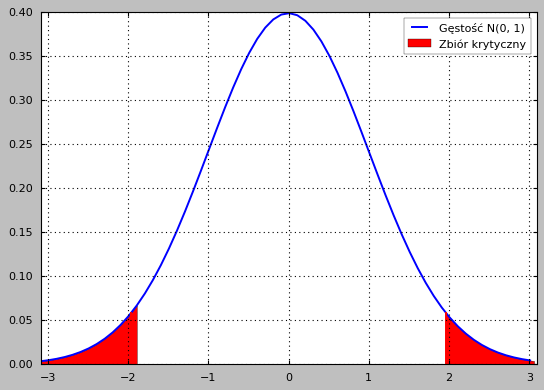

In [74]:
plot_mean_test(1.5, 0.2, 0.05, data1, "not_equal")

Test dla średniej przeciwko $H_1: \mu < 1.5$

p-wartość (dla H1: mu < 1.5): 9.51241291241344e-13
Przyjęto hipotezę zerową: Nie
Wartość statystyki testowej: -7.041450899607091


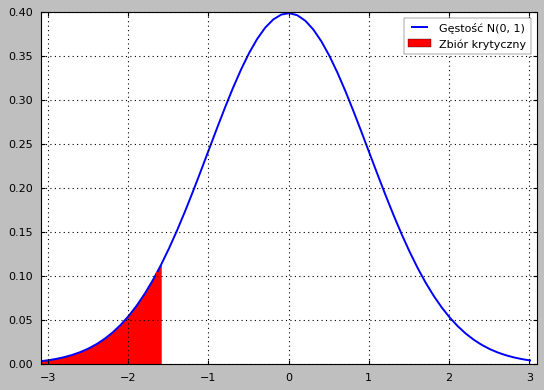

In [77]:
plot_mean_test(1.5, 0.2, 0.05, data1, "less")

Test dla średniej przeciwko $H_1: \mu > 1.5$

p-wartość (dla H1: mu > 1.5): 0.9999999999990488
Przyjęto hipotezę zerową: Tak
Wartość statystyki testowej: -7.041450899607091


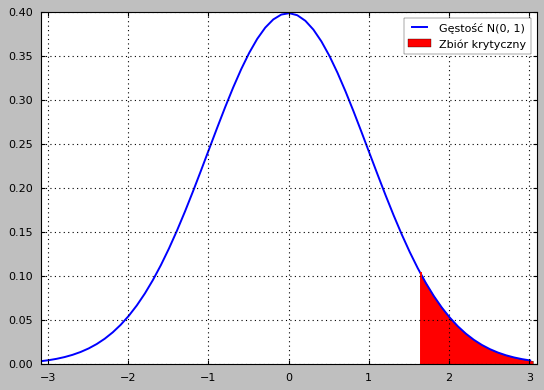

In [78]:
plot_mean_test(1.5, 0.2, 0.05, data1, "greater")

### Zadanie 2

In [26]:
"""
Test statystyczny dla wariancji.
Zwraca:
    p-wartość,
    wynik testu,
    wartości krytyczne,
    statystykę testową 
"""
def test_for_var(
        var,                     # wariancja rozkładu przy założeniu hipotezy zerowej
        alpha,                   # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):
    
    
    # Statystyka testowa (rozkład Chi^2)

    x2 = (len(sample) - 1) * np.var(sample) / var
    dist = st.chi2(len(sample) - 1)

    
    # Wartości krytyczne 

    if alternative == "not_equal":
        lower_bound = dist.ppf(alpha/2)
        upper_bound = dist.ppf(1 - alpha/2)         
    elif alternative == "less":
        lower_bound = dist.ppf(alpha)
        upper_bound = None
    elif alternative == "greater":
        lower_bound = None
        upper_bound = dist.ppf(1 - alpha)
    else:
        raise Exception("Podano nieprawidłową hipotezę alternatywną")    
    
    
    # p-wartość

    if alternative == "not_equal":
        if x2 >= (len(sample) - 1):
            pvalue = 2 * (1 - dist.cdf(x2))
        else:
            pvalue = 2 * dist.cdf(x2)
    elif alternative == "less":
        pvalue = dist.cdf(x2)
    else:
        pvalue = 1 - dist.cdf(x2)

    result = x2 < upper_bound if not lower_bound else (
             x2 > lower_bound if not upper_bound else lower_bound < x2 < upper_bound
    )

    return (pvalue, result, (lower_bound, upper_bound), x2)
    

In [79]:
"""
Wykres zbioru krytycznego dla wariancji
"""
def plot_var_test(
        var,                     # wariancja rozkładu przy założeniu hipotezy zerowej
        alpha,                   # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):
        
    pvalue, result, (lower_bound, upper_bound), x2 = test_for_var(var, alpha, sample, alternative)

    alt_hypo = "sigma^2 != 1.5" if alternative == "not_equal" else (
               "sigma^2 < 1.5" if alternative == "less" else "sigma^2 > 1.5"
    )

    print(f"p-wartość (dla H1: {alt_hypo}): {pvalue}")
    print(f"Przyjęto hipotezę zerową: {'Tak' if result else 'Nie'}")
    print(f"Wartość statystyki testowej: {x2}")

    plt.show(plot_test(x2, lower_bound, upper_bound, st.chi2(len(sample) - 1)))
    
    

Dane dla zadania drugiego

In [81]:
data2 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad2.txt")

Test dla wariancji przeciwko $H_1: \sigma^2 \ne 1.5$

p-wartość (dla H1: sigma^2 != 1.5): 0.016011673877854404
Przyjęto hipotezę zerową: Nie
Wartość statystyki testowej: 1109.8574804526054


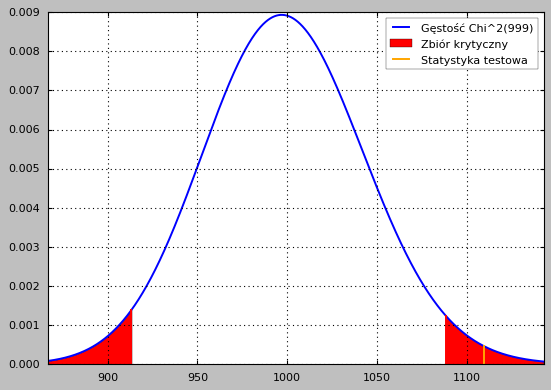

In [82]:
plot_var_test(1.5, 0.05, data2, alternative="not_equal")

Test dla wariancji przeciwko $H_1: \sigma^2 < 1.5$

p-wartość (dla H1: sigma^2 < 1.5): 0.9919941630610728
Przyjęto hipotezę zerową: Tak
Wartość statystyki testowej: 1109.8574804526054


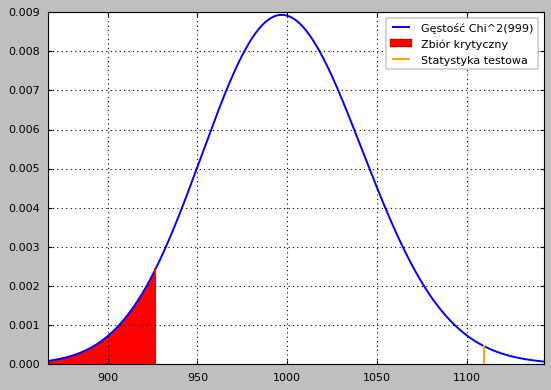

In [83]:
plot_var_test(1.5, 0.05, data2, alternative="less")

Test dla wariancji przeciwko $H_1: \sigma^2 > 1.5$

p-wartość (dla H1: sigma^2 > 1.5): 0.008005836938927202
Przyjęto hipotezę zerową: Nie
Wartość statystyki testowej: 1109.8574804526054


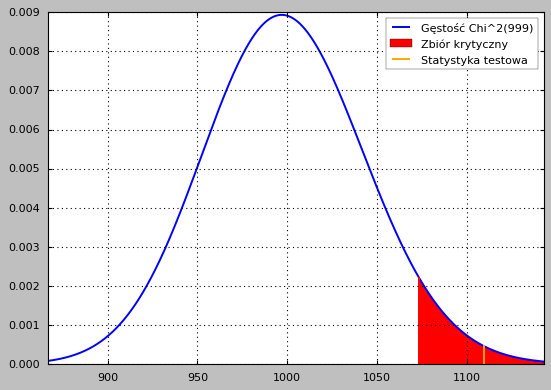

In [84]:
plot_var_test(1.5, 0.05, data2, alternative="greater")

Zwiększanie poziomu istotności testu statystycznego prowadzi do zwiększenia się powierzchni zbioru krytycznego, a co za tym idzie do **zwiększenia się prawdopodobieństwa popełnienia błędu I rodzaju**. Gdy poziom istotności przekroczy p-wartość dojdzie też do zmianu wyniku testu (odrzucenia hipotezy zerowej na korzyść alternatywnej). Jednakże skutkuje to też większym prawdopodobieństwem odrzucenia hipotezy zerowej gdy jest ona fałszywa, to jest **zwiększeniem mocy testu**. 

Analogicznie, gdy będziemy zmniejszać poziom istotności, razem z nim będzie **maleć** prawdopodobieństwo popełnienia **błędu I rodzaju** jak i **moc testu**.

### Zadanie 3

#### Błąd I rodzaju

In [28]:
"""
Model liniowy do dopasowywania do danych
"""
def linear(x, a, b):
    return a * x + b

In [29]:
"""
Prawdopodobieństwo popełnienia błędu I rodzaju
dla danego poziomu istotności testu
"""
def type_one_err(
        mean,                    # średnia rozkładu
        var,                     # wariancja rozkładu 
        alpha,                   # poziom istotności testu
        test_func,               # użyty test
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek
):
    
    tests_failed = num_of_runs

    for _ in range(num_of_runs):

        sample = np.random.normal(mean, np.sqrt(var), 1000)
        args = (mean, np.sqrt(var), alpha, sample, alternative) if test_func == test_for_mean else (var, alpha, sample, alternative)
        tests_failed -= test_func(*args)[1]

    return tests_failed / num_of_runs



In [91]:
"""
Wykres p-stwa popełnienia błędu I rodzaju 
w zależności od poziomu istotności 
"""
def plot_type_one_errs(
        mean,                    # średnia rozkładu
        var,                     # wariancja rozkładu 
        alphas,                   # zakres poziomu istotności
        test_func,               # użyty test
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek dla każdego poziomu istotności

):
    
    errs = np.array([type_one_err(mean, np.sqrt(var), alpha, test_func, alternative, num_of_runs) for alpha in alphas])
    
    popt, _ = curve_fit(linear, alphas, errs)


    plt.plot(alphas, alphas, label="Poziom ufności")
    plt.scatter(alphas, errs, label="Błędy I rodzaju", c="green")
    plt.plot(alphas, popt[0] * alphas + popt[1], label="Dopasowany model liniowy", c="red")
    plt.xlabel("Poziom istotności")
    plt.ylabel("P-stwo popełnienia błędu I rodzaju")
    plt.legend(loc="upper left")
    plt.grid()

    plt.show()

In [92]:
"""
Przedstawienie rozkładu p-stwa popełnienia błędu I rodzaju
za pomocą histogramu
"""
def hist_type_one_errs(
        mean,                    # średnia rozkładu
        var,                     # wariancja rozkładu 
        alpha,                    # poziom istotności
        test_func,               # użyty test
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek dla każdego poziomu istotności
):
    
    errs = np.array([type_one_err(mean, np.sqrt(var), alpha, test_func, alternative, num_of_runs) for _ in range(100)])
    
    print(f"Poziom istotności: {alpha}")
    print(f"Średnie p-stwo popełnienia błędu I rodzaju: {np.mean(errs)}")

    plt.hist(errs, density=True)
    plt.title(f"Rozkład prawdopodobieństw błędów I rodzaju dla poziomu istotności: {alpha}")
    plt.grid()
    plt.show()

In [94]:
"""
Przedstawienie rozkładu p-stwa popełnienia błędu I rodzaju
za pomocą wykresu pudełkowego
"""
def boxplot_type_one_errs(
        mean,                    # średnia rozkładu
        var,                     # wariancja rozkładu 
        alpha,                   # poziom istotności
        test_func,               # użyty test
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek dla każdego poziomu istotności
):

    errs = np.array([type_one_err(mean, np.sqrt(var), alpha, test_func, alternative, num_of_runs) for _ in range(100)])

    print(f"Poziom istotności: {alpha}")
    print(f"Średnie p-stwo popełnienia błędu I rodzaju: {np.mean(errs)}")

    plt.boxplot(errs)
    plt.title(f"Wykres pudełkowy p-stwa błędów dla poziomu istotności: {alpha}")
    plt.grid()
    plt.show()

**Błąd I rodzaju dla średniej**

Wykres prawdopodobieństwa popełnienia błędu I rodzaju w teście dla średniej w zależności od poziomu istotności testu wraz z linią trendu.

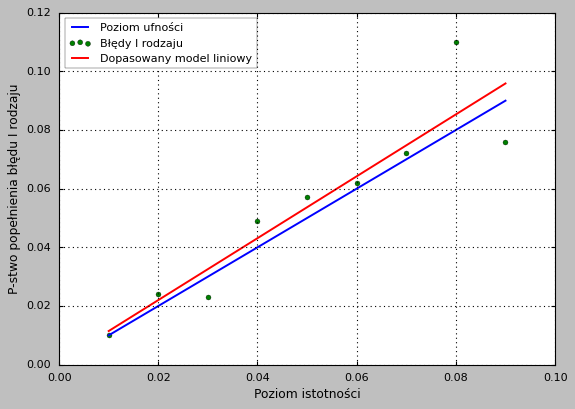

In [96]:
plot_type_one_errs(0, 1, np.arange(0.01, 0.1, 0.01), test_for_mean)

Histogram rozkładu prawdopodobieństwa popełnienia błędu I rodzaju dla ustalonego poziomu istotności testu

Poziom istotności: 0.05
Średnie p-stwo popełnienia błędu I rodzaju: 0.05022999999999999


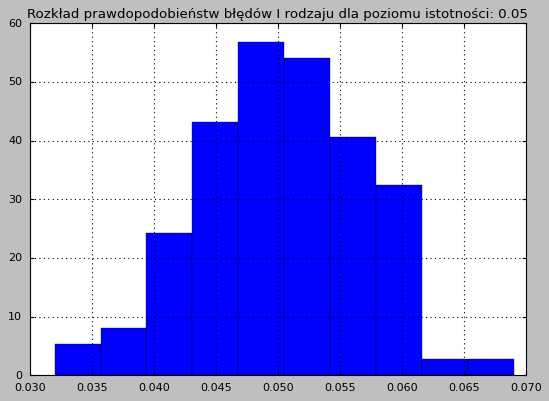

In [97]:
hist_type_one_errs(0, 1, 0.05, test_for_mean)

Wykres pudełkowy dla tego samego rozkładu

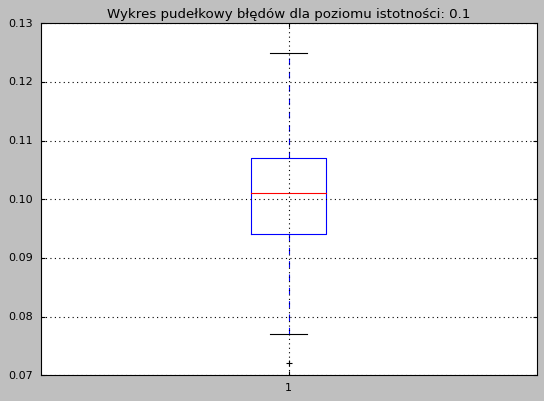

In [72]:
boxplot_type_one_errs(0, 1, 0.1, test_for_mean)

**Błąd I rodzaju dla wariancji**

Wykres prawdopodobieństwa popełnienia błędu I rodzaju w teście dla średniej w zależności od poziomu istotności testu wraz z linią trendu.

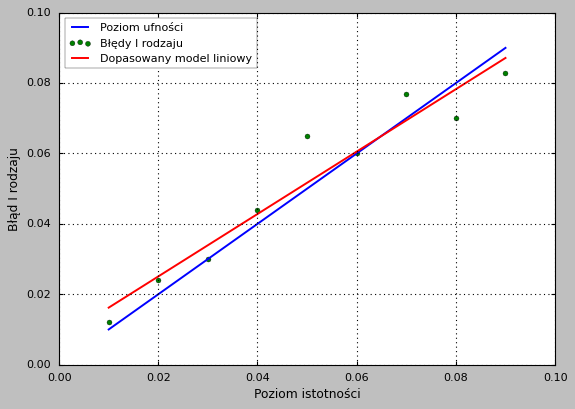

In [76]:
plot_type_one_errs(0, 1, np.arange(0.01, 0.1, 0.01), test_for_var)

Histogram rozkładu prawdopodobieństwa popełnienia błędu I rodzaju dla ustalonego poziomu istotności testu

Poziom istotności: 0.03
Średnie p-stwo popełnienia błędu I rodzaju: 0.03058000000000001


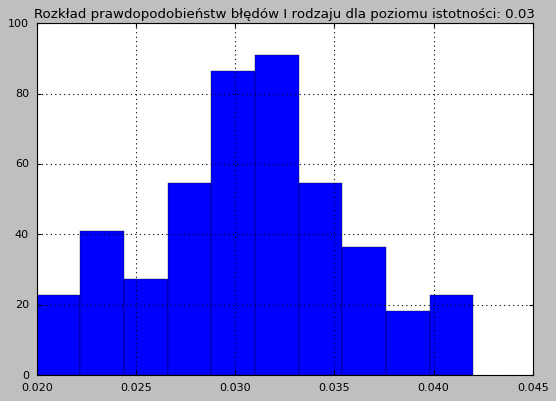

In [99]:
hist_type_one_errs(0, 1, 0.03, test_for_var)

Wykres pudełkowy tego samego rozkładu

Średni błąd I rodzaju: 0.19881000000000001


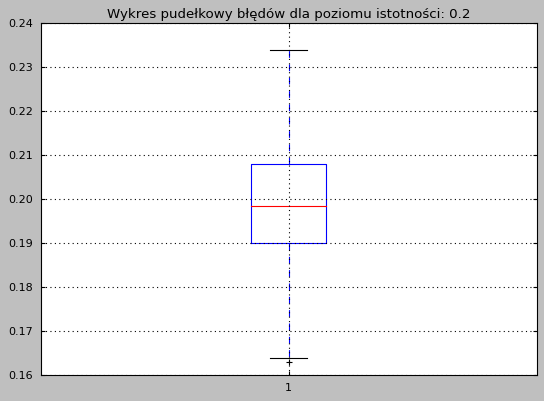

In [79]:
boxplot_type_one_errs(0, 1, 0.2, test_for_var)

#### Błąd II rodzaju

Błąd II rodzaju dla średniej

In [35]:
"""
Prawdopodobieństwo popełnienia błędu II rodzaju dla średniej,
przy założeniu, że w hipotezie zerowej mu = 1.5 oraz sigma = 0.2
"""
def type_two_err_mean(
        mean,                       # średnia rozkładu, z którego pochodzi testowana próbka
        alpha,                      # poziom istotności testu
        alternative="not_equal",    # hipoteza alternatywna
        num_of_runs=1000            # ilość przeprowadzonych testów
):
    
    # Ilość testów, w których przyjęto hipotezę zerową mimo, że była fałszywa
    successful_tests = 0

    for _ in range(num_of_runs):
        sample = np.random.normal(1.5, 0.2, 1000)
        successful_tests += test_for_mean(mean, 0.2, alpha, sample, alternative)[1]

    return successful_tests/num_of_runs


In [111]:
def plot_type_two_errs_mean(
        means,                   # średnie rozkładów 
        alpha,                   # zakres poziomu istotności
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek dla każdego poziomu istotności
):
    
    errs = np.array([type_two_err_mean(mean, alpha, alternative, num_of_runs) for mean in means])
    
    plt.plot(means - 1.5, errs, label="P-stwo popełnienia błędu II rodzaju", marker="v", markersize=7)
    plt.plot(means - 1.5, 1 - errs, label="Moc testu", marker="^", markersize=7)
    plt.xlabel("Różnica pomiędzy średnią zerową, a średnią rzeczywistą")
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.1), loc="upper left", mode="expand")
    plt.grid()

    plt.show()

Wykres prawdopodobieństwa popełnienia błędu II rodzaju w teście dla średniej oraz mocy testu w zależności od różnicy między średnią zgodną z hipotezą zerową a średnią rzeczywistą.

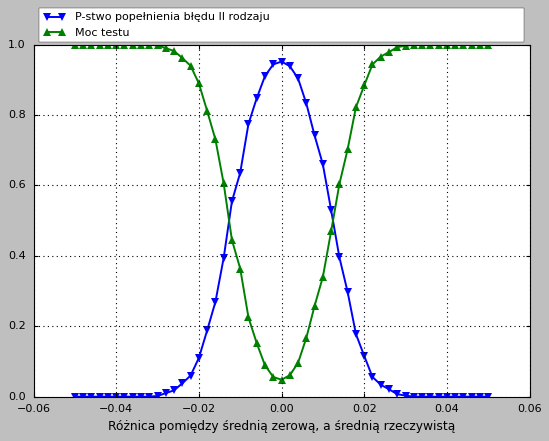

In [112]:
plot_type_two_errs_mean(np.arange(1.45, 1.55, 0.002), 0.05)

**Błąd II rodzaju dla wariancji**

In [142]:
"""
Prawdopodobieństwo popełnienia błędu II rodzaju dla wariancji,
przy założeniu, że w hipotezie zerowej mu = 0.2 oraz sigma = 1.5
"""
def type_two_err_var(
        var,                        # wariancja rozkładu, z którego pochodzi testowana próbka
        alpha,                      # poziom istotności testu
        alternative="not_equal",    # hipoteza alternatywna
        num_of_runs=1000            # ilość przeprowadzonych testów
):
    
    # Ilość testów, w których przyjęto hipotezę zerową mimo, że była fałszywa
    successful_tests = 0

    for _ in range(num_of_runs):
        sample = np.random.normal(0.2, np.sqrt(1.5), 1000)
        successful_tests += test_for_var(var, alpha, sample, alternative)[1]

    return successful_tests/num_of_runs


In [114]:
def plot_type_two_errs_var(
        vars,                    # wariancje rozkładów 
        alpha,                   # zakres poziomu istotności
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek dla każdego poziomu istotności
):
    
    errs = np.array([type_two_err_var(var, alpha, alternative, num_of_runs) for var in vars])
    
    plt.plot(vars - 1.5, errs, label="P-stwo popełnienia błędu II rodzaju", marker="v", markersize=7)
    plt.plot(vars - 1.5, 1 - errs, label="Moc testu", marker="^", markersize=7)
    plt.xlabel("Różnica pomiędzy wariancją zerową, a wariancją rzeczywistą")
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.1), loc="upper left", mode="expand")
    plt.grid()

    plt.show()

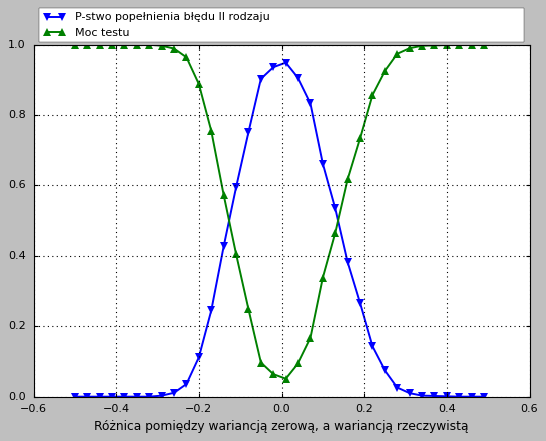

In [158]:
plot_type_two_errs_var(np.arange(1, 2, 0.03), 0.05)

Jak widać z dwóch powyższych wykresów test dla wariancji wymaga o wiele większej różnicy między rzeczywistą wartością parametru a wartością w hipotezie zerowej aby zniwelować prawdopodobieństwo zajścia błędu II rodzaju, niż test dla średniej. Można stwierdzić, że test dla średniej jest *"bardziej dokładny"* niż test dla wariancji.